# Electrode Analysis with Graph
This analysis is based on the steps carried out in ElectrodeDemo. The final graph shows the amount of unscathed gold by radius, which

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
plt.style.use('evanstyle.mplstyle')

In [19]:
x_min = -4
x_max = 50
y_min = 0
y_max = 6
grid_increment = 2
x_dim = int((x_max-x_min)/grid_increment + 1)
y_dim = int((y_max-y_min)/grid_increment + 1)

gold_area = np.ones((x_dim, y_dim))
gold_area = np.negative(gold_area)

In [27]:
indir = 'Gold Set 2/'
regex = re.compile(r'^y(\d+)_x(\d+)\.JPG$')
filenames = os.listdir(indir)
file_list = [f for f in map(regex.match, filenames) if f is not None]
df = pd.DataFrame()

In [48]:
for f in file_list:
    
    ds = pd.Series(dtype='float64')
    ds['x'] = int(f.group(2))
    #print(str(f.group(1)))
    ds['y'] = int(f.group(1))
    
    
    #load image
    #path_name = 'Gold Set 2/y{}_x{}.JPG'.format(j, i) #flipped
    #print(path_name)
    #src = cv2.imread(path_name)
    print(indir + f.group(0))
    src = cv2.imread(indir + f.group(0))
    
    if src is None: #shouldn't be
        continue
    
    #Create RGB, Grayscale, and Binary transformations
    original = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    imgray = cv2.cvtColor(original,cv2.COLOR_BGR2GRAY)
    _,alpha = cv2.threshold(imgray,55,255,cv2.THRESH_BINARY_INV)
    alpha = cv2.GaussianBlur(alpha, (21,21), cv2.BORDER_DEFAULT)
    
    #Using Hough Circle, find scope area
    hough_circle = cv2.HoughCircles(alpha, cv2.HOUGH_GRADIENT, 1.5, 100, param1=50,param2=30,minRadius=0,maxRadius=0)
    hough_circle = np.round(hough_circle[0, 0,:])
    (x,y) = (int(hough_circle[0]), int(hough_circle[1]))
    r = int(hough_circle[2])
    hc_area = np.pi*r**2
    
    #Delete all external area with bitwise_and
    circlemask = np.zeros(original.shape, dtype=np.uint8)
    cv2.circle(circlemask, (x,y), r, (255,255,255), -1)
    circlemask = cv2.cvtColor(circlemask,cv2.COLOR_BGR2GRAY)
    ROI = cv2.bitwise_and(original,original, mask=circlemask)
        
    #Transform to HSV, set upper and lower bounds of gold color, and find binary image with this gold range
    hsvimage = cv2.cvtColor(ROI, cv2.COLOR_RGB2HSV)
    lower = np.array([17, 137, 200], dtype="uint8")
    upper = np.array([50, 190, 255], dtype="uint8")
    goldmask = cv2.inRange(hsvimage, lower, upper)

    #Clean up binary image to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(goldmask, cv2.MORPH_OPEN, kernel, iterations=1)

    #Only consider contours with significant area, draw all contours
    cnts = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnt_area = 0
    for c in cnts:
        currcontour = cv2.contourArea(c)
        if currcontour >= 2000:
            cnt_area += currcontour
            cv2.drawContours(ROI,[c], 0, (0,0,255), 2)
        
    #Calculating Area:
    perarea = cnt_area/hc_area
    #print('Contour area/Circle area = '+ str(cnt_area)+'/'+ str(hc_area)+' = ' +str(perarea))
    if perarea > 1:
        perarea = 1 
    #print(perarea)
        
    #insert into array
    
    print(str(perarea))
    ds['area'] = perarea
    #print(ds)
    df = df.append(ds, ignore_index=True)
    #print(df)

Gold Set 2/y6_x8.JPG
0.47267456594786034
Gold Set 2/y6_x50.JPG
0.9811208109560846
Gold Set 2/y6_x44.JPG
1
Gold Set 2/y4_x20.JPG
0.2778810413990823
Gold Set 2/y4_x34.JPG
0.825261555743574
Gold Set 2/y0_x14.JPG
0.26296656530348206
Gold Set 2/y0_x28.JPG
0.026449506514057818
Gold Set 2/y0_x16.JPG
0.3127247928372641
Gold Set 2/y4_x22.JPG
0.0033690004472912392
Gold Set 2/y4_x36.JPG
0.8702971404985563
Gold Set 2/y6_x46.JPG
1
Gold Set 2/y6_x42.JPG
1
Gold Set 2/y4_x32.JPG
0.2740071990683431
Gold Set 2/y4_x26.JPG
0.011340367203639764
Gold Set 2/y0_x12.JPG
0.21748358552625124
Gold Set 2/y0_x10.JPG
0.6414555288038771
Gold Set 2/y0_x38.JPG
0.9717070279285996
Gold Set 2/y4_x30.JPG
0.18223010411857044
Gold Set 2/y4_x24.JPG
0.12271770670253612
Gold Set 2/y4_x8.JPG
0.9300629479796261
Gold Set 2/y4_x18.JPG
0.2590022862501792
Gold Set 2/y6_x40.JPG
1
Gold Set 2/y4_x42.JPG
0.8896441210879383
Gold Set 2/y2_x12.JPG
0.3485007284420624
Gold Set 2/y6_x26.JPG
0.08627066122944012
Gold Set 2/y6_x32.JPG
0.437012422

In [72]:
df = df.sort_values(by=['y'])
print(df)

        area  x   y
98  0.990104  4   0
81  1.000000  6   0
63  0.952485  2   0
55  1.000000  0   0
99  0.732825  4  10
..       ... ..  ..
43  0.981559  2   8
23  0.930063  4   8
36  0.573560  0   8
4   0.472675  6   8
0   0.472675  6   8

[103 rows x 3 columns]


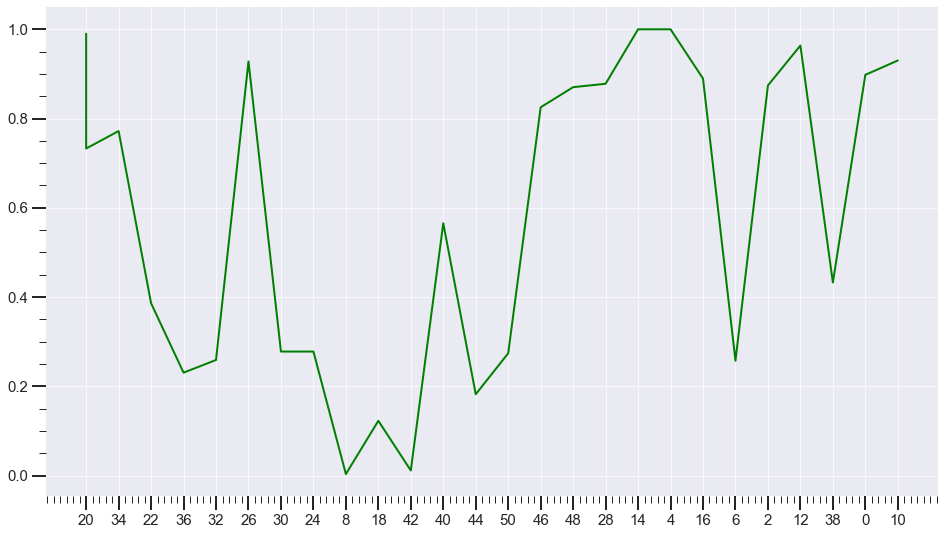

In [73]:
mask = (df['x'] == '4')
x = df['y'][mask]
areas = df['area'][mask]

fig = plt.figure(figsize=(16,9))
plt.plot(xs, areas, color ='green')
plt.show()